<a href="https://colab.research.google.com/github/nainaroy20/Question-Categorizer/blob/main/QC20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset
from transformers import TrainingArguments
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
!pip install transformers[torch]

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
df= pd.read_csv("data.csv")
df = df.sample(frac=1.0, random_state=42)

df.head()

,QUESTIONN,CATEGORY
1222,Differentiate between microcontrollers and mic...,Differentiation
111,Analyze the impact of increasing the clock spe...,Analytical
554,What is a binary search tree? Explain.,Definition
526,Define pipelining in the context of processor ...,Definition
1310,Formulate the principles of a binary search tr...,Formulation


In [ ]:
labels = df['CATEGORY'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Differentiation',
 'Analytical',
 'Definition',
 'Formulation',
 'Theory Information',
 'Statistical',
 'Mathematical',
 'Inferencial']

In [ ]:
for key, value in enumerate(labels):
    print(value)

Differentiation
Analytical
Definition
Formulation
Theory Information
Statistical
Mathematical
Inferencial


In [ ]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [ ]:
label2id

{'Differentiation': 0,
 'Analytical': 1,
 'Definition': 2,
 'Formulation': 3,
 'Theory Information': 4,
 'Statistical': 5,
 'Mathematical': 6,
 'Inferencial': 7}

In [ ]:
id2label

{0: 'Differentiation',
 1: 'Analytical',
 2: 'Definition',
 3: 'Formulation',
 4: 'Theory Information',
 5: 'Statistical',
 6: 'Mathematical',
 7: 'Inferencial'}

In [ ]:
df["labels"]=df.CATEGORY.map(lambda x: label2id[x.strip()])

<Axes: ylabel='CATEGORY'>

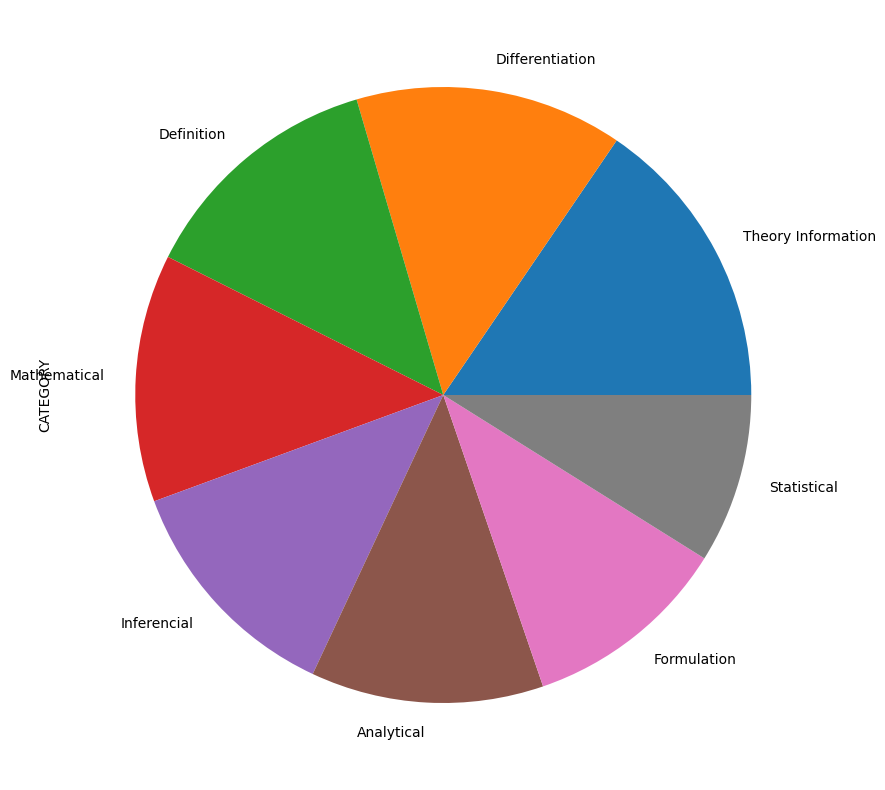

In [ ]:
df.CATEGORY.value_counts().plot(kind='pie', figsize=(10,10))

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
SIZE= df.shape[0]

train_texts= list(df.QUESTIONN[:SIZE//2])

val_texts=   list(df.QUESTIONN[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df.QUESTIONN[(3*SIZE)//4:])

train_labels= list(df.labels[:SIZE//2])

val_labels=   list(df.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df.labels[(3*SIZE)//4:])

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(949, 475, 475)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
!pip install accelerate>=0.20.1 transformers[torch]

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.2', '0.26.1')

In [ ]:
!pip install accelerate -U


In [ ]:
training_args = TrainingArguments(
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.889400,1.419765,0.720000,0.641315,0.702511,0.688578
100,0.856200,0.232624,0.949474,0.911873,0.953861,0.910926
150,0.142300,0.046703,0.993684,0.992530,0.992641,0.992447
200,0.053800,0.053276,0.991579,0.988926,0.987447,0.990636
250,0.017400,0.045333,0.991579,0.988642,0.987474,0.990090
300,0.012200,0.027887,0.995789,0.994401,0.994401,0.994401
350,0.005900,0.027532,0.995789,0.994401,0.994401,0.994401


TrainOutput(global_step=360, training_loss=0.4136841251825293, metrics={'train_runtime': 92.5035, 'train_samples_per_second': 61.554, 'train_steps_per_second': 3.892, 'total_flos': 242877948719328.0, 'train_loss': 0.4136841251825293, 'epoch': 6.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df) for df in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.003956,1.000000,1.000000,1.000000,1.000000
val,0.027871,0.995789,0.994401,0.994401,0.994401
test,0.062795,0.989474,0.988784,0.988481,0.989167


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()
     # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
QUESTIONN = "Evaluate the trade-offs between pipelined and non-pipelined processor architectures."
# "Machine Learning itself is moving towards more and more automated"
predict(QUESTIONN)

(tensor([[4.1288e-04, 9.9666e-01, 6.2599e-04, 6.1030e-04, 5.8469e-04, 2.6287e-04,
          4.0863e-04, 4.3892e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(1, device='cuda:0'),
 'Analytical')

In [ ]:
#SAVE MODEL FOR INFERENCE
model_path = "question-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('question-classification-model/tokenizer_config.json',
 'question-classification-model/special_tokens_map.json',
 'question-classification-model/vocab.txt',
 'question-classification-model/added_tokens.json')

In [ ]:
#Re-Load saved model for inference
model_path = "question-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("text-classification", model=model, tokenizer=tokenizer)

In [ ]:
nlp("What is (-10)/225*-9*175/20?")

[{'label': 'Mathematical', 'score': 0.9971919655799866}]

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Assuming true_labels and predicted_labels are arrays containing true and predicted labels
true_labels = np.array(['Mathematical', 'Inferencial', 'Differentiation', 'Definition', 'Analytical','Formulation', 'Statistical'])  # Replace with your true labels
predicted_labels = np.array(['Mathematical', 'Inferencial', 'Differentiation', 'Definition', 'Analytical','Formulation', 'Statistical'])  # Replace with your predicted labels

# Get unique category labels
unique_labels = np.unique(true_labels)

# Initialize dictionaries to store metrics for each category
precision_dict = {}
recall_dict = {}
f1_dict = {}
accuracy_dict = {}

# Calculate precision, recall, and F1 score for each category
for label in unique_labels:
    mask = (true_labels == label)
    category_true_labels = true_labels[mask]
    category_predicted_labels = predicted_labels[mask]

    precision, recall, f1, _ = precision_recall_fscore_support(
        category_true_labels, category_predicted_labels, average='weighted'
    )

    accuracy = accuracy_score(category_true_labels, category_predicted_labels)

    precision_dict[label] = precision
    recall_dict[label] = recall
    f1_dict[label] = f1
    accuracy_dict[label] = accuracy

# Display results for each category
for label in unique_labels:
    print(f"Category: {label}")
    print(f"Precision: {precision_dict[label]}")
    print(f"Recall: {recall_dict[label]}")
    print(f"F1 Score: {f1_dict[label]}")
    print(f"Accuracy: {accuracy_dict[label]}")
    print("------------------")


Category: Analytical
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
------------------
Category: Definition
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
------------------
Category: Differentiation
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
------------------
Category: Formulation
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
------------------
Category: Inferencial
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
------------------
Category: Mathematical
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
------------------
Category: Statistical
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
------------------
